In [1]:
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline
import seaborn as sns
import torch
import pandas as pd
import torchvision
from tqdm.notebook import tqdm
from torchvision.io import read_image
from torch.utils.data import Dataset
from torchvision.transforms import Normalize
import torchsummary
from torch.optim import lr_scheduler
from pytorch_lightning.callbacks import Callback
import torch.nn as nn
from tempfile import TemporaryDirectory
import time
%matplotlib inline
matplotlib_inline.backend_inline.set_matplotlib_formats("svg", "pdf")  # For export
sns.reset_orig()
sns.set()


# PyTorch TensorBoard support
from torch.utils.tensorboard import SummaryWriter
# Tensorboard extension (for visualization purposes later)
%load_ext tensorboard
# Setting the seed

# Ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print("Device:", device)

Device: cpu


## Create a training dataset

In [2]:
shots = [16769, 16773]#, 16534, 16769, 16773, 18057]
shot_df = pd.DataFrame([])
for shot in shots:
    df = pd.read_csv(f'/compass/Shared/Users/bogdanov/vyzkumny_ukol/LHmode-detection-shot{shot}.csv')
    shot_df = pd.concat([shot_df, df], axis=0)

df_mode = shot_df['mode'].copy()
df_mode[shot_df['mode']=='L-mode']=0
df_mode[shot_df['mode']=='H-mode']=1
df_mode[shot_df['mode']=='ELM']=2
shot_df['mode'] = df_mode
shot_df = shot_df.reset_index(drop=True) #each shot has its own indexing starting from 0 to 2232

# Precalculated mean and std for each color and each image 
#TODO: Do i have to calculate mean and std everytime I add new shot do database?
mean, std = pd.read_csv('normalization.csv', index_col=0).values

In [3]:
class ImageDataset(Dataset):
    def __init__(self, annotations, img_dir, mean, std):
        self.img_labels = annotations #pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.mean = mean
        self.std = std

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.loc[idx, 'filename'])
        image = read_image(img_path).double()
        normalized_image = (image - self.mean[:, None, None])/self.std[:, None, None]
        label = self.img_labels.iloc[idx, 1]
        return image, label#normalized_image, label
    

    
dataset = ImageDataset(annotations=shot_df[['filename', 'mode']], img_dir='/compass/Shared/Users/bogdanov/vyzkumny_ukol',\
                        mean=mean, std=std)

### TODO: adjust dataset sizes

In [4]:
from torch.utils.data import DataLoader
train_dataloader = DataLoader(dataset, batch_size=4, shuffle=True)
test_dataloader = DataLoader(dataset, batch_size=4, shuffle=True)
val_dataloader = DataLoader(dataset, batch_size=4, shuffle=False)

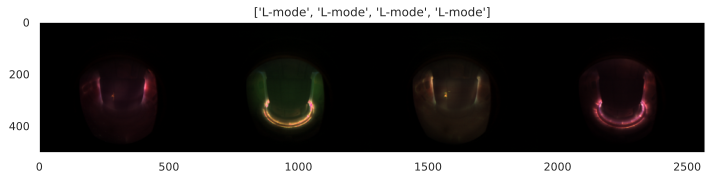

In [84]:
def imshow(inp, mean, std, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    inp = inp/255
    inp = np.clip(inp, 0, 1)
    plt.figure(figsize=(12,16))
    plt.imshow(inp)
    plt.grid(False)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

class_names = ['L-mode', 'H-mode', 'ELM']
# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))
# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, mean=mean, std=std, title=[class_names[x] for x in classes])

In [41]:
image = next(iter(train_dataloader))[0][3]
print(f'mean: {image.mean()} \n std: {image.std()}\n max: {image.max()}')

mean: 4.635057291666667 
 std: 9.526375551298916
 max: 161.0


In [14]:
dataloaders = {'train':train_dataloader, 'val':test_dataloader} #TODO: add test loader in train function and consequenlty to this dict
dataset_sizes = {x: len(dataloaders[x].dataset) for x in ['train', 'val']}

## Import pretrained model

## Playing with TensorBoard

In [15]:
pretrained_model = torchvision.models.resnet18(weights='IMAGENET1K_V1')

num_ftrs = pretrained_model.fc.in_features
# Here the size of each output sample is set to 3.
# Alternatively, it can be generalized to ``nn.Linear(num_ftrs, len(class_names))``.
pretrained_model.fc = torch.nn.Linear(num_ftrs, 3) #3 classes: L-mode, H-mode, ELM


### I will try to freeze all layers except 4-th and fc layer

In [16]:
# for name, para in pretrained_model.named_parameters():
#     if "layer4" in name or "fc" in name:
#         continue
#     else:
#         para.requires_grad = False

### Alternatively freeze all the weights excepts those of last fc layer

In [17]:
for param in pretrained_model.parameters():
    param.requires_grad = False
 
# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = pretrained_model.fc.in_features
pretrained_model.fc = nn.Linear(num_ftrs, 3) #3 classes: L-mode, H-mode, ELM

In [18]:
pretrained_model = pretrained_model.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer = torch.optim.SGD(pretrained_model.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

### Here I simply print the structure of model for input with size (3,500,640)

In [19]:
#torchsummary.summary(pretrained_model, (3,500,640))

In [20]:
# for name, para in pretrained_model.named_parameters():
#     print("="*40)
#     print(f"name: {name}")
#     print(para)

In [39]:
inputs, classes = next(iter(dataloaders['train']))
torchvision.utils.make_grid(inputs).size()

torch.Size([3, 504, 2570])

In [ ]:
def matplotlib_imshow(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    if one_channel:
        plt.imshow(npimg, cmap="Greys")
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))

# Extract a batch of 4 images
dataiter = iter(training_loader)
images, labels = next(dataiter)

# Create a grid from the images and show them
img_grid = torchvision.utils.make_grid(images)
matplotlib_imshow(img_grid, one_channel=True)

## Training
### Training function was copied from [tutorial](https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html#finetuning-the-convnet)

In [13]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    # Create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')
    
        torch.save(model.state_dict(), best_model_params_path)
        best_acc = 0.0

        for epoch in range(num_epochs):
            print(f'Epoch {epoch}/{num_epochs - 1}')
            print('-' * 10)

            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()  # Set model to training mode
                else:
                    model.eval()   # Set model to evaluate mode

                running_loss = 0.0
                running_corrects = 0

                # Iterate over data.
                for inputs, labels in dataloaders[phase]:
                    inputs = inputs.to(device).float() #TODO: is it smart to convert double to float here?
                    labels = labels.to(device)

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs) #2D tensor with shape Batchsize*len(class_names)
                        #TODO: inputs.type. 
                        _, preds = torch.max(outputs, 1) #preds = 1D array of indicies of maximum values in row. ([2,1,2,1,2]) - third feature is largest in first sample, second in second...
                        loss = criterion(outputs, labels)

                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # statistics
                    running_loss += loss.item() * inputs.size(0) #!!! Why is it multiplied by batchsize???
                    running_corrects += torch.sum(preds == labels.data) #How many correct answers
                if phase == 'train':
                    scheduler.step()

                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]

                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

                # deep copy the model
                if phase == 'val' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    torch.save(model.state_dict(), best_model_params_path)

            print()

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val Acc: {best_acc:4f}')

        # load best model weights
        model.load_state_dict(torch.load(best_model_params_path))
    return model

In [14]:
model = train_model(pretrained_model, criterion, optimizer,
                         exp_lr_scheduler, num_epochs=2)

Epoch 0/1
----------
we train
we train
we train
we train
we train
we train
we train
we train
we train
we train
we train
we train
we train
we train
we train
we train
we train
we train
we train
we train
we train
we train
we train
we train
we train
we train
we train
we train
we train
we train
we train
we train
we train


KeyboardInterrupt: 